# Preprate the global grids

Load them and convert to netCDF with proper CF metadata.

In [1]:
import lzma
import os
import xarray as xr
import numpy as np
import harmonica as hm
import pooch

## Geoid

In [2]:
with lzma.open("EIGEN-6C4_geoid.gdf.xz", "rt") as f:
    geoid_dataset = hm.load_icgem_gdf(f)
geoid_icgem_metadata = geoid_dataset.attrs.copy()
geoid = geoid_dataset.geoid.astype("float32")
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

Set the proper metadata.

In [3]:
geoid.attrs = {
    "Conventions": "CF-1.8",
    "title": "Geoid height (EIGEN-6C4) with respect to WGS84",
    "institution": "GFZ German Research Centre for Geosciences and GRGS/CNES Toulouse",
    "crs": "WGS84",
    "source": "Generated from the EIGEN-6C4 model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "https://doi.org/10.5880/icgem.2015.1",
    "long_name": "geoid height",
    "standard_name": "geoid_height_above_reference_ellipsoid",
    "description": "height of the geoid with respect to the WGS84 ellipsoid",
    "units": "m",
    "actual_range": (geoid.values.min(), geoid.values.max()),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in geoid_icgem_metadata.items()]),
}
geoid.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (geoid.longitude.values.min(), geoid.longitude.values.max()),
}
geoid.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (geoid.latitude.values.min(), geoid.latitude.values.max()),
}
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes: (12/13)
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    institution:     GFZ German Research Centre for Geosciences and GRGS/CNES...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    ...              ...
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    (-106.5244, 85.964165)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

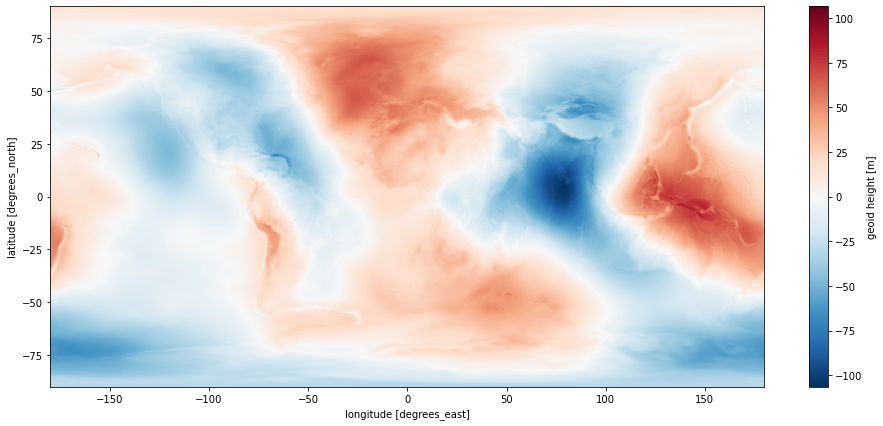

In [4]:
geoid.plot(figsize=(16, 7))

## Gravity

In [5]:
with lzma.open("EIGEN-6C4_gravity.gdf.xz", "rt") as f:
    gravity_dataset = hm.load_icgem_gdf(f)
gravity_dataset

<xarray.Dataset>
Dimensions:          (latitude: 1081, longitude: 2161)
Coordinates:
  * longitude        (longitude) float64 -180.0 -179.8 -179.7 ... 179.8 180.0
  * latitude         (latitude) float64 -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
Data variables:
    gravity_ell      (latitude, longitude) float64 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 1e+04 1e+04 ... 1e+04 1e+04
Attributes: (12/33)
    generating_institute:  gfz-potsdam
    generating_date:       2021/06/11
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       720
    ...                    ...
    maxvalue:              9.8020189E+05 mgal
    minvalue:              9.7474860E+05 mgal
    signal_wrms:           1.5468191E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

Put height as a coordinate.

In [6]:
gravity_icgem_metadata = gravity_dataset.attrs.copy()
dims = ("latitude", "longitude")
gravity = xr.DataArray(
    gravity_dataset.gravity_ell.astype("float32"),
    coords={
        "longitude": gravity_dataset.longitude,
        "latitude": gravity_dataset.latitude,
        "height": gravity_dataset.height_over_ell.astype("float32")[0, 0],
    },
    dims=dims,
    name="gravity",
)
gravity

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.56, 980106.56, 980106.56, ..., 980106.56, 980106.56,
        980106.56],
       [980108.2 , 980108.2 , 980108.2 , ..., 980108.2 , 980108.2 ,
        980108.2 ],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.7 , 980153.6 , ..., 980153.94, 980153.9 ,
        980153.8 ],
       [980160.44, 980160.4 , 980160.4 , ..., 980160.44, 980160.44,
        980160.44],
       [980157.56, 980157.56, 980157.56, ..., 980157.56, 980157.56,
        980157.56]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     float32 1e+04

Set the proper metadata.

In [7]:
gravity.attrs = {
    "Conventions": "CF-1.8",
    "title": "Gravity acceleration (EIGEN-6C4) at a constant geometric height",
    "institution": "GFZ German Research Centre for Geosciences and GRGS/CNES Toulouse",
    "crs": "WGS84",
    "source": "Generated from the EIGEN-6C4 model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "https://doi.org/10.5880/icgem.2015.1",
    "long_name": "gravity acceleration",
    "description": "magnitude of the gravity acceleration vector",
    "units": "mGal",
    "actual_range": (gravity.values.min(), gravity.values.max()),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in gravity_icgem_metadata.items()]),
}
gravity.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (gravity.longitude.values.min(), gravity.longitude.values.max()),
}
gravity.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (gravity.latitude.values.min(), gravity.latitude.values.max()),
}
gravity.height.attrs = {
    "long_name": "geometric height",
    "standard_name": "height_above_reference_ellipsoid",
    "description": "height of gravity computation points above the WGS84 ellipsoid",
    "units": "m",
    "actual_range": (gravity.height.values.min(), gravity.height.values.max()),
}
gravity

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.56, 980106.56, 980106.56, ..., 980106.56, 980106.56,
        980106.56],
       [980108.2 , 980108.2 , 980108.2 , ..., 980108.2 , 980108.2 ,
        980108.2 ],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.7 , 980153.6 , ..., 980153.94, 980153.9 ,
        980153.8 ],
       [980160.44, 980160.4 , 980160.4 , ..., 980160.44, 980160.44,
        980160.44],
       [980157.56, 980157.56, 980157.56, ..., 980157.56, 980157.56,
        980157.56]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     float32 1e+04
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    institution:     GFZ German Research Centre for Geosciences and GRGS/CNES...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector
    units:           mGal
    actual_range:    (974748.6, 980201.9)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

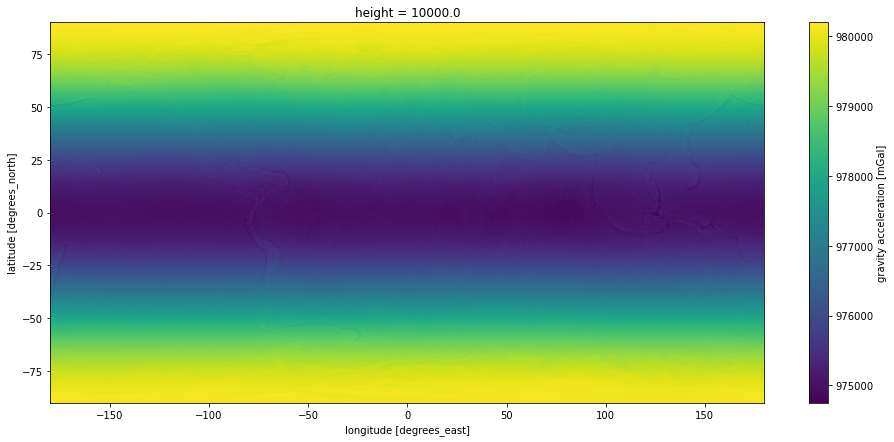

In [8]:
gravity.plot(figsize=(16, 7))

## Topography

In [9]:
with lzma.open("etopo1.gdf.xz", "rt") as f:
    topo_dataset = hm.load_icgem_gdf(f)
topo_icgem_metadata = topo_dataset.attrs.copy()
topo = topo_dataset.topography_shm.rename("topography").astype("float32")
topo

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2741.967 ,  2741.967 ,  2741.967 , ...,  2741.967 ,  2741.967 ,
         2741.967 ],
       [ 2768.2942,  2768.1946,  2768.095 , ...,  2768.493 ,  2768.3936,
         2768.2942],
       [ 2821.9172,  2821.685 ,  2821.4526, ...,  2822.3804,  2822.149 ,
         2821.9172],
       ...,
       [-4243.443 , -4244.1055, -4244.761 , ..., -4242.097 , -4242.7734,
        -4243.443 ],
       [-4156.4565, -4156.5615, -4156.666 , ..., -4156.246 , -4156.3516,
        -4156.4565],
       [-4236.9985, -4236.9985, -4236.9985, ..., -4236.9985, -4236.9985,
        -4236.9985]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

Set the proper metadata.

In [10]:
topo.attrs = {
    "Conventions": "CF-1.8",
    "title": "Topographic and bathymetric height of ETOPO1 (ice surface) at 10 arc-minute resolution",
    "institution": "National Geophysical Data Center, National Oceanic and Atmospheric Administration",
    "crs": "WGS84",
    "source": "Generated from a spherical harmonic model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "public domain",
    "references": "https://doi.org/10.7289/V5C8276M",
    "long_name": "topographic height above mean sea level",
    "standard_name": "height_above_mean_sea_level",
    "description": "height topography/bathymetry referenced to mean sea level",
    "units": "m",
    "actual_range": (topo.values.min(), topo.values.max()),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in topo_icgem_metadata.items()]),
}
topo.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (topo.longitude.values.min(), topo.longitude.values.max()),
}
topo.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (topo.latitude.values.min(), topo.latitude.values.max()),
}
topo

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2741.967 ,  2741.967 ,  2741.967 , ...,  2741.967 ,  2741.967 ,
         2741.967 ],
       [ 2768.2942,  2768.1946,  2768.095 , ...,  2768.493 ,  2768.3936,
         2768.2942],
       [ 2821.9172,  2821.685 ,  2821.4526, ...,  2822.3804,  2822.149 ,
         2821.9172],
       ...,
       [-4243.443 , -4244.1055, -4244.761 , ..., -4242.097 , -4242.7734,
        -4243.443 ],
       [-4156.4565, -4156.5615, -4156.666 , ..., -4156.246 , -4156.3516,
        -4156.4565],
       [-4236.9985, -4236.9985, -4236.9985, ..., -4236.9985, -4236.9985,
        -4236.9985]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes: (12/13)
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    institution:     National Geophysical Data Center, National Oceanic and A...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    ...              ...
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    (-10023.31, 6081.633)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

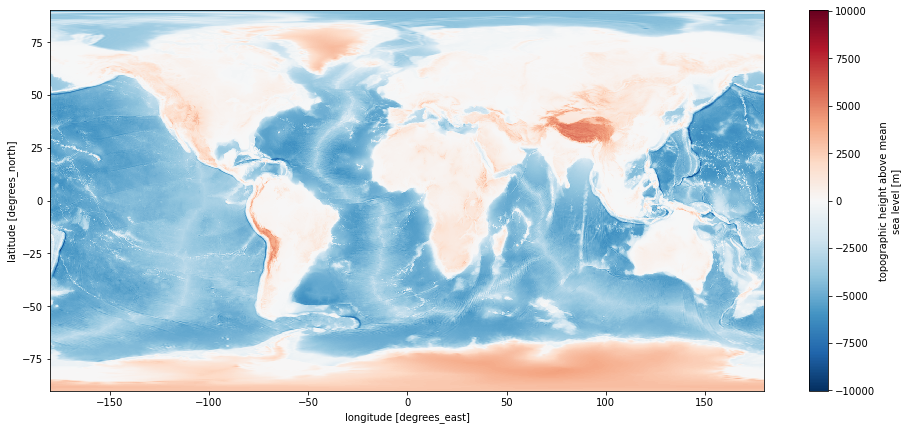

In [11]:
topo.plot(figsize=(16, 7))

## Save to netCDF

In [12]:
fname = "gravity-earth-10arcmin.nc"
gravity.to_netcdf(fname, format="NETCDF4")
print(f"{fname}: md5:{pooch.file_hash(fname, alg='md5')}")
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

gravity-earth-10arcmin.nc: md5:976a4c4fff6f14701502d19d5132c82a
size: 9.387803 Mb


In [13]:
fname = "geoid-earth-10arcmin.nc"
geoid.to_netcdf(fname, format="NETCDF4")
print(f"{fname}: md5:{pooch.file_hash(fname, alg='md5')}")
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

geoid-earth-10arcmin.nc: md5:d6e9a3870a09e4903ec0bc681ddc11c3
size: 9.385106 Mb


In [14]:
fname = "topography-earth-10arcmin.nc"
topo.to_netcdf(fname, format="NETCDF4")
print(f"{fname}: md5:{pooch.file_hash(fname, alg='md5')}")
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

topography-earth-10arcmin.nc: md5:8538dd9401d0fe799913f1d411e60313
size: 9.384109 Mb
